# Tensorflow Object Detection API

## Instalacion de Object Detection API

In [1]:
! git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3407, done.
remote: Counting objects: 100% (3407/3407), done.
remote: Compressing objects: 100% (2833/2833), done.
remote: Total 3407 (delta 891), reused 1391 (delta 517), pack-reused 0
Receiving objects: 100% (3407/3407), 34.97 MiB | 16.62 MiB/s, done.
Resolving deltas: 100% (891/891), done.


In [28]:
! sudo pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 23 kB/s 
     |████████████████████████████████| 1.3 MB 35.4 MB/s 
     |████████████████████████████████| 463 kB 71.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.9.2 req

In [2]:
! sudo apt install protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.


In [3]:
%cd models/research

/content/models/research


In [4]:
! protoc object_detection/protos/*.proto --python_out=.

In [5]:
! cp object_detection/packages/tf2/setup.py .

In [25]:
! python -m pip install -q .

ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


## Preprocesamiento del Dataset

In [7]:
%cd ..
%cd ..

/content/models
/content


In [8]:
! mkdir ~/.kaggle
! cp drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download mbkinaci/fruit-images-for-object-detection

 95% 27.0M/28.4M [00:00<00:00, 62.4MB/s]
100% 28.4M/28.4M [00:00<00:00, 51.9MB/s]


In [10]:
! unzip fruit-images-for-object-detection.zip
! rm fruit-images-for-object-detection.zip

Archive:  fruit-images-for-object-detection.zip
  inflating: test_zip/test/apple_77.jpg  
  inflating: test_zip/test/apple_77.xml  
  inflating: test_zip/test/apple_78.jpg  
  inflating: test_zip/test/apple_78.xml  
  inflating: test_zip/test/apple_79.jpg  
  inflating: test_zip/test/apple_79.xml  
  inflating: test_zip/test/apple_80.jpg  
  inflating: test_zip/test/apple_80.xml  
  inflating: test_zip/test/apple_81.jpg  
  inflating: test_zip/test/apple_81.xml  
  inflating: test_zip/test/apple_82.jpg  
  inflating: test_zip/test/apple_82.xml  
  inflating: test_zip/test/apple_83.jpg  
  inflating: test_zip/test/apple_83.xml  
  inflating: test_zip/test/apple_84.jpg  
  inflating: test_zip/test/apple_84.xml  
  inflating: test_zip/test/apple_85.jpg  
  inflating: test_zip/test/apple_85.xml  
  inflating: test_zip/test/apple_86.jpg  
  inflating: test_zip/test/apple_86.xml  
  inflating: test_zip/test/apple_87.jpg  
  inflating: test_zip/test/apple_87.xml  
  inflating: test_zip/test/a

Preprocesamiento

In [20]:
import tensorflow as tf
import io
import os
import glob
from PIL import Image
from xml.etree import ElementTree as tree
from object_detection.utils import dataset_util
import pandas as pd

In [12]:
from collections import namedtuple
def split(df, group):
  data = namedtuple('data', ['filename', 'object'])
  groups = df.groupby(group)
  return [data(filename, groups.get_group(x)) for filename, x in
          zip(groups.groups.keys(), groups.groups)]

In [13]:
def map_class(row_label):
  md = {
      'apple': 1, 'orange': 2, 'banana': 3
  }
  return md.get(row_label, None)

In [14]:
def create_tf_example(group, path):
  groups_path = os.path.join(path, group.filename)
  with tf.io.gfile.GFile(groups_path, 'rb') as file:
    img_bytes = file.read()
  img = Image.open(io.BytesIO(img_bytes))
  width, height = img.size

  filename = group.filename.encode('utf8')
  img_format = b'jpg'

  xmins = []
  xmaxs = []
  ymins = []
  ymaxs = []
  classes_text = []
  classes = []

  for index, row in group.object.iterrows():
    xmins.append(row['xmin'] / width)
    xmaxs.append(row['xmax'] / width)
    ymins.append(row['ymin'] / height)
    ymaxs.append(row['ymax'] / height)
    classes_text.append(row['class'].encode('utf8'))
    classes.append(map_class(row['class']))

  features = tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(img_bytes),
      'image/format': dataset_util.bytes_feature(img_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes)
  })

  return tf.train.Example(features=features)

In [15]:
def xml_to_csv(path):
  xmls = []
  path_pattern = path + '*.xml'
  for xml in glob.glob(path_pattern):
    t = tree.parse(xml)
    root = t.getroot()
    for element in root.findall('object'):
      val = (root.find('filename').text,
             int(root.find('size')[0].text), # w
             int(root.find('size')[1].text), # h
             element[0].text, # nombre
             int(element[4][0].text),
             int(element[4][1].text),
             int(element[4][2].text),
             int(element[4][3].text),) 
      xmls.append(val)
  columns = ['filename', 'width', 'height', 'class', 
             'xmin', 'ymin', 'xmax', 'ymax']
  df = pd.DataFrame(xmls, columns=columns)
  return df

In [16]:
# Prueba para fenerar el dataframe
df = xml_to_csv('/content/train_zip/train/')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,banana_65.jpg,640,427,banana,170,37,498,339
1,banana_65.jpg,640,427,banana,54,114,452,371
2,banana_65.jpg,640,427,banana,126,31,438,226
3,orange_70.jpg,0,0,orange,368,109,706,470
4,orange_70.jpg,0,0,orange,58,69,410,432


In [17]:
# Iteramos sobre los conjuntos
for subset in ['test', 'train']:
  path = '{subset}_zip/{subset}/'.format(subset = subset)
  path_out = '{}.csv'.format(subset)
  df = xml_to_csv(path)
  df.to_csv(path_out, index=None)

  writer = tf.io.TFRecordWriter('{}.record'.format(subset))
  groups = split(df, 'filename')
  for group in groups:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
  
  writer.close()

## Modelo para deteccion de objetos

In [18]:
# Descargamos el modelo
! wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz

--2022-07-10 21:55:00--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.12.128, 2404:6800:4003:c0f::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.12.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M  --.-KB/s    in 0.1s    

2022-07-10 21:55:00 (242 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]



In [19]:
%%writefile label_map.txt
item{
  id: 1,
  name: 'apple'
}
item{
  id: 2,
  name: 'orange'
}
item{
  id: 3,
  name: 'banana'
}

Writing label_map.txt


In [20]:
# Modificar el modelo

In [21]:
! tar -xvf /content/efficientdet_d0_coco17_tpu-32.tar.gz

efficientdet_d0_coco17_tpu-32/
efficientdet_d0_coco17_tpu-32/checkpoint/
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d0_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0.index
efficientdet_d0_coco17_tpu-32/pipeline.config
efficientdet_d0_coco17_tpu-32/saved_model/
efficientdet_d0_coco17_tpu-32/saved_model/saved_model.pb
efficientdet_d0_coco17_tpu-32/saved_model/assets/
efficientdet_d0_coco17_tpu-32/saved_model/variables/
efficientdet_d0_coco17_tpu-32/saved_model/variables/variables.data-00000-of-00001
efficientdet_d0_coco17_tpu-32/saved_model/variables/variables.index


In [3]:
%cd models/research/object_detection/

/content/models/research/object_detection


In [23]:
! pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [27]:
import tensorflow as tf
tf.__version__

'2.9.1'

In [8]:
! export CUDA_VISIBLE_DEVICES=0

In [10]:
! python model_main_tf2.py --pipeline_config_path=/content/models/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config --model_dir=/content/ --num_train_steps=10000

2022-07-10 22:26:06.365823: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0710 22:26:06.369192 139778801301376 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0710 22:26:06.374402 139778801301376 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0710 22:26:06.374561 139778801301376 config_util.py:552] Maybe overwriting use_bfloat16: False
I0710 22:26:06.384049 139778801301376 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet EfficientNet backbone version: efficientnet-b0
I0710 22:26:06.384156 139778801301376 ssd_efficientnet_bifpn_feature_extractor.py:147

In [12]:
# Exportar el grafico de inferencia
! python exporter_main_v2.py --trained_checkpoint_dir=/content/ --pipeline_config_path=/content/models/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config --output_directory=/content/inference_graph

2022-07-10 22:48:12.405758: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0710 22:48:12.422608 140531183150976 ssd_efficientnet_bifpn_feature_extractor.py:146] EfficientDet EfficientNet backbone version: efficientnet-b0
I0710 22:48:12.422843 140531183150976 ssd_efficientnet_bifpn_feature_extractor.py:147] EfficientDet BiFPN num filters: 64
I0710 22:48:12.422931 140531183150976 ssd_efficientnet_bifpn_feature_extractor.py:149] EfficientDet BiFPN num iterations: 3
I0710 22:48:12.426438 140531183150976 efficientnet_model.py:143] round_filter input=32 output=32
I0710 22:48:12.471024 140531183150976 efficientnet_model.py:143] round_filter input=32 output=32
I0710 22:48:12.471188 140531183150976 efficientnet_model.py:143] round_filter input=16 output=16
I0710 22:48:12.619376 140531183150976 efficientnet_model.py:143] round_filter input=16 output=16
I

## Funcion para la inferencia

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
from object_detection.utils import ops
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils.label_map_util import create_category_index_from_labelmap

In [22]:
model_path = '/content/inference_graph/saved_model'
model = tf.saved_model.load(model_path)

category_index = create_category_index_from_labelmap('/content/label_map.txt')

In [49]:
def infer_img(img_path, model):
  img = Image.open(img_path)
  width, height = img.size
  img = np.array(img)
  inp_tensor = tf.convert_to_tensor(img)
  inp_tensor = inp_tensor[tf.newaxis, ...]
  detections = model(inp_tensor)
  n_detect = int(detections.pop('num_detections'))
  detections = {key: value[0, :n_detect].numpy() for key, value in detections.items()}
  detections['num_detections'] = n_detect

  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
  # Podemos extraer las mascaras
  if 'detection_mask' in detections:
    detection_mask = ops.reframe_box_masks_to_image_masks(detections['detection_mask'],
                                                          detections['detection_boxes'],
                                                          img.shape[0],
                                                          img.shape[1])
    detection_mask = tf.cast(detection_mask > 0.5, tf.unit8)
    detections['detection_mask'] = detection_mask.numpy()
  masks = detections.get('detection_mask',None)
  # ---------
  img2 = img.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      img2, 
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      instance_masks = masks,
      use_normalized_coordinates=True,
      max_boxes_to_draw = 15,
      min_score_thresh = 0.0,
  )
  return img2

Probamos el modelo

In [50]:
test_img = '/content/test_zip/test/apple_77.jpg'

img2 = infer_img(test_img, model)

In [32]:
%matplotlib inline

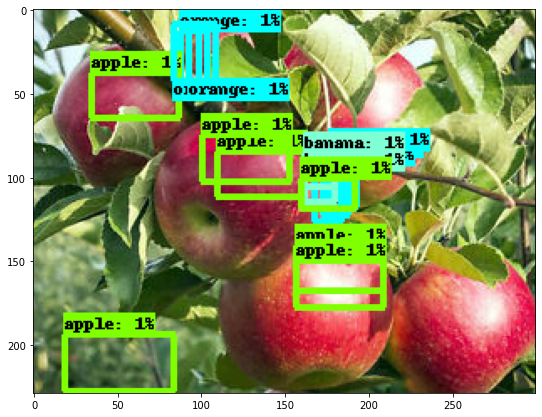

In [51]:
plt.figure(figsize=(9,9))
plt.imshow(img2)
plt.show()